In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from glob import glob
from src.tool import * 
from src.piece_process import *
from src.tile import *

img_paths = glob("input/*.jpg")
img_path = img_paths[0]

img = cv2.imread(img_path)
img_warped = get_warp_image(img, margin=20)
img_balanced = white_balance(img_warped)
mask = find_outline_rough(img_balanced)

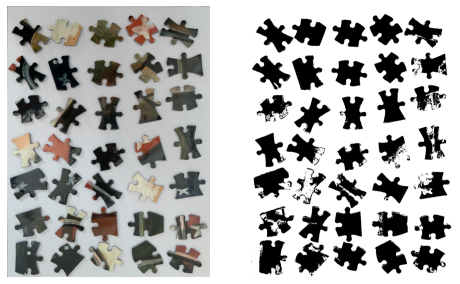

In [2]:
show([img_balanced, mask])

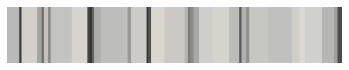

35


In [3]:
img_overlap = kmeans_color_purifier(mask, img_balanced)
pieces_mask, output = pieces_searching(img_overlap)
print(len(pieces_mask))

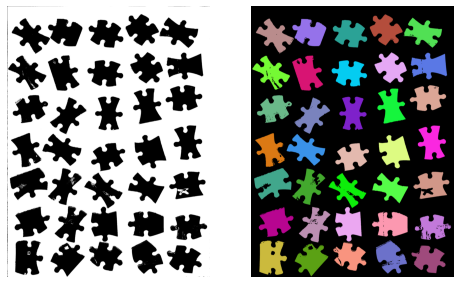

In [4]:
show([img_overlap, output])

In [ ]:
pieces = []
piece_masks = []
for piece in pieces_mask:
    image_area = piece.shape[0] * piece.shape[1]  
    piece_mask_cropped, piece_cropped = crop_piece(piece, img_balanced)
    piece_mask_refined = refine_piece(piece_mask_cropped, image_area)
    pieces.append(piece_cropped)
    piece_masks.append(piece_mask_refined)

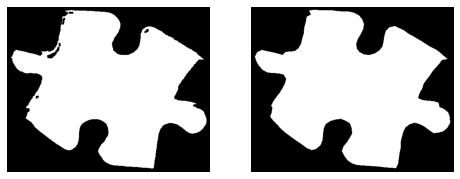

In [6]:
show([piece_mask_cropped, piece_mask_refined])

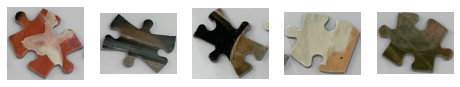

In [7]:
show(pieces[:5])

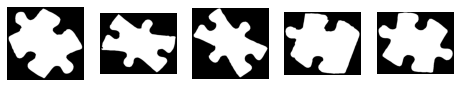

In [8]:
show(piece_masks[:5])

In [9]:
corners = []
for piece_mask in piece_masks:
    corners.append(get_tile_corners(piece_mask))

/Users/ji.tang/OneDrive - Accenture/Documents - Cloud/Github/jigsaw-puzzle-solver/src/piece_process.py:62: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)


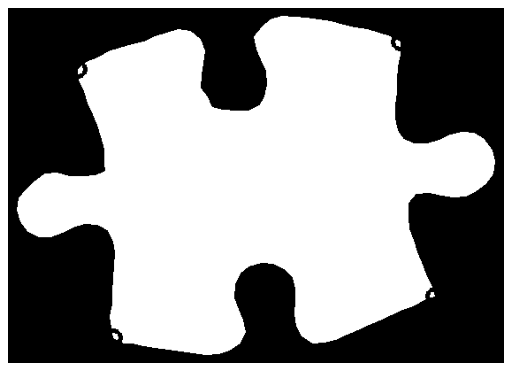

In [10]:
i = 10
annotate_points(piece_masks[i], corners[i])

In [39]:
tiles = []
for i in range(len(piece_masks)):
    tiles.append(Tile(pieces[i], piece_masks[i], corners[i]))

In [374]:
def connect_tiles(tile1, tile2):
    dim = (tile1.img.shape[0]+tile2.img.shape[0], max(tile1.img.shape[1],tile2.img.shape[1]), 3) #TODO someting's wrong here -> find out!
    img = np.zeros((1000,1000,3))
    img = overlay_image_alpha(img, tile1.img, (0,0), tile1.mask)
    x_offset = tile1.corners[1][0]-tile2.corners[0, 0]
    y_offset = 17 # TODO: currently manual tryout -> calculate
    img = overlay_image_alpha(img, tile2.img, (x_offset, y_offset), tile2.mask)
    img = cv2.circle(img, tuple(tile1.corners[1]), 8, (255,0,0), thickness=6)
    img = cv2.circle(img, (tile2.corners[0][0]+x_offset, tile2.corners[0][1]+y_offset), 17, (255,0,0), thickness=6)
    return img

In [28]:
b = np.ones((400*7,400*5,3), dtype=np.uint8)*255
for i, t in enumerate(tiles):
    t.scale(0.5)
    overlay_image_alpha(b, t.img, np.array([i%5 * 400,i//5 * 400])+100-t.corners[0][0], t.mask)

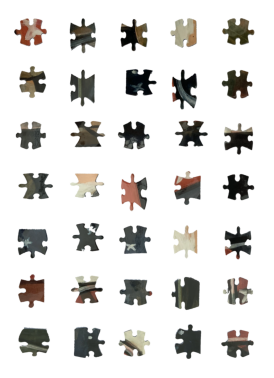

In [29]:
show([b])

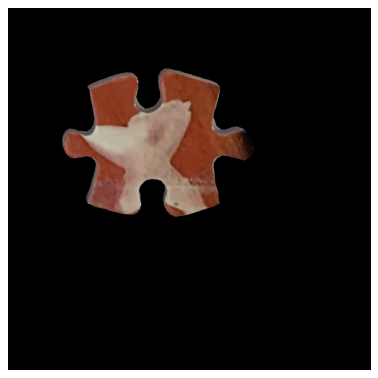

In [375]:
t = tiles[0]
t.rotate()
test = overlay_image_alpha(np.zeros((1000,1000,3), dtype=np.uint8), t.img, (0,0), t.mask)
show([test])

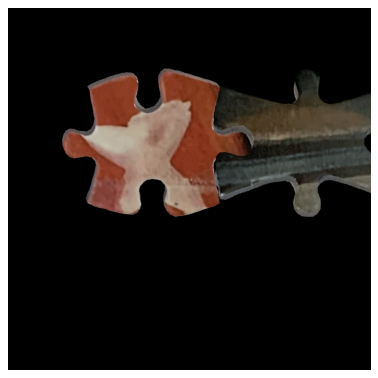

In [376]:
t2 = tiles[1]
test2 = overlay_image_alpha(test, t2.img, t.corners[1]-t2.corners[0], t2.mask)
show([test2])